<a href="https://colab.research.google.com/github/zahraDehghanian97/Adversarially-Learned-Anomaly-Detection/blob/master/toy_experiments/ALAD%20-%20toy%20example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# ALAD - Toy examples

This is the notebook that generated Figure 2 in "Adversarially learnt anomaly detection"
Credits : https://github.com/ChunyuanLI/ALICE

### Imports

In [1]:
%matplotlib inline
import os
import pdb
import sys
py_file_location = "/content/drive/MyDrive/Colab Notebooks/Adversarially-Learned-Anomaly-Detection-master/toy_experiments/utils"
sys.path.append(os.path.abspath(py_file_location))

In [2]:
%tensorflow_version 1.x
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import tensorflow as tf
from data_gmm import GMM_distribution, sample_GMM, plot_GMM
from data_utils import shuffle, iter_data, ToyDataset
from tqdm import tqdm
import sklearn.datasets

slim = tf.contrib.slim
ds = tf.contrib.distributions
graph_replace = tf.contrib.graph_editor.graph_replace

TensorFlow 1.x selected.
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



### Parameters

In [3]:
DATASET = '4gaussians' # 5gaussians, swiss_roll, s_curve
N_NOISY = 100

In [4]:
""" parameters """
n_epoch = 300
batch_size  = 1024
dataset_size_x = 512*4
dataset_size_z = 512*4

dataset_size_x_test = 512*2
dataset_size_z_test = 512*2

input_dim = 2
latent_dim = 2
eps_dim = 2

n_layer_disc  = 2
n_hidden_disc = 256
n_layer_gen   = 3
n_hidden_gen  = 256
n_layer_inf   = 2
n_hidden_inf  = 256

In [6]:
""" Create directory for results """
result_dir = 'results/alad_toy/'
directory = result_dir
if not os.path.exists(directory):
    os.makedirs(directory)

## Training dataset

#### 4 or 5 GMM

In [7]:
""" Create dataset """

def four_five_gaussians(p1=0):
    # create X dataset
    global dataset_size_x
    means_x = map(lambda x:  np.array(x), [[2, 2],[-2, -2],[2, -2],[-2, 2],[0, 0]])
    means_x = list(means_x)
    std_x = 0.02
    variances_x = [np.eye(2) * std_x for _ in means_x]
    #contamination = 4.0*p/(1-p)
    priors_x = np.array([1.0, 1.0, 1.0, 1.0, p1])
    priors_x /= sum(priors_x)
    #print(priors_x)
    gaussian_mixture = GMM_distribution(means=means_x,variances=variances_x,priors=priors_x)
    dataset_x = sample_GMM(dataset_size_x, means_x, variances_x, priors_x, sources=('features', ))
    return dataset_x

You can control the level of the fifth gaussian in the training set with the $p$ parameter

Generate training dataset

In [8]:
dataset_x = four_five_gaussians(p1=0)
save_path_x = result_dir + 'X_4gmm_data_train.png'


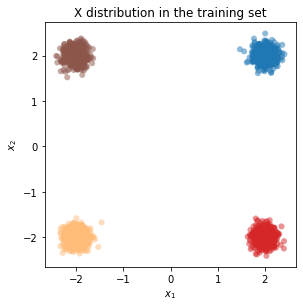

In [9]:
## input x
X_dataset  = dataset_x.data['samples']
X_targets = dataset_x.data['label']

fig_mx, ax = plt.subplots(nrows=1, ncols=1, figsize=(4.5, 4.5))
ax.scatter(X_dataset[:, 0], X_dataset[:, 1], c=cm.tab20(X_targets.astype(float)/input_dim/3.0),
           edgecolor='none', alpha=0.5)
#ax.set_xlim(-3, 3); ax.set_ylim(-3.5, 3.5)
ax.set_xlabel('$x_1$'); ax.set_ylabel('$x_2$')
ax.set_title("X distribution in the training set" )
ax.axis('on')
plt.savefig(save_path_x, transparent=True, bbox_inches='tight')
plt.show()

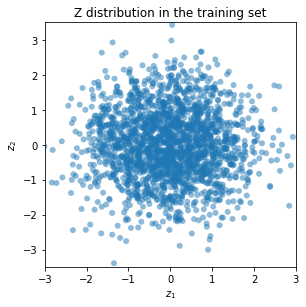

In [10]:
# create Z dataset
means_z = map(lambda x:  np.array(x), [[0, 0]])
means_z = list(means_z)
std_z = 1.0
variances_z = [np.eye(2) * std_z for _ in means_z]
priors_z = [1.0/len(means_z) for _ in means_z]

dataset_z = sample_GMM(dataset_size_z, means_z, variances_z, priors_z, sources=('features', ))
save_path_z = result_dir + 'Z_gmm_data_train.png'

##  input z
Z_dataset = dataset_z.data['samples']
Z_labels  = dataset_z.data['label']

fig_mx, ax = plt.subplots(nrows=1, ncols=1, figsize=(4.5, 4.5))
ax.scatter(Z_dataset[:, 0], Z_dataset[:, 1],
           edgecolor='none', alpha=0.5)
ax.set_xlim(-3, 3); ax.set_ylim(-3.5, 3.5)
ax.set_xlabel('$z_1$'); ax.set_ylabel('$z_2$')
ax.set_title("Z distribution in the training set")
ax.axis('on')
plt.savefig(save_path_z, transparent=True, bbox_inches='tight')
plt.show()

## Network

In [12]:
""" Networks """

def generative_network(z, input_dim, n_layer, n_hidden, eps_dim, reuse=False):
    with tf.variable_scope("generative", reuse=reuse):
        h = slim.stack(z, slim.fully_connected, [n_hidden] * n_layer, activation_fn=tf.nn.relu)
        x = slim.fully_connected(h, input_dim, activation_fn=None)
    return x


def inference_network(x, latent_dim, n_layer, n_hidden, eps_dim, reuse=False):
    with tf.variable_scope("inference", reuse=reuse):
        h = slim.stack(x, slim.fully_connected, [n_hidden] * n_layer, activation_fn=tf.nn.relu)
        z = slim.fully_connected(h, latent_dim, activation_fn=None)      
    return z

def data_network_xz(x, z, n_layers=2, n_hidden=128, activation_fn=None,reuse=False):
    """Approximate x log data density."""
    h = tf.concat([x,z], 1)
    with tf.variable_scope('discriminator', reuse=reuse):
        h = slim.stack(h, slim.fully_connected, [n_hidden] * n_layers, activation_fn=tf.nn.relu)
        log_d = slim.fully_connected(h, 1, activation_fn=None)
    return tf.squeeze(log_d, squeeze_dims=[1])

def data_network_xx(x,x_hat, n_layers=1, n_hidden=128, activation_fn=None, reuse=False):
    """Approximate x log data density."""
    # pdb.set_trace()
    h = tf.concat([x,x_hat], 1)
    with tf.variable_scope('discriminator_xx', reuse=reuse):
        h = slim.stack(h, slim.fully_connected, [n_hidden] * n_layers, activation_fn=tf.nn.relu)
        log_d = slim.fully_connected(h, 1, activation_fn=activation_fn)
    return tf.squeeze(log_d, squeeze_dims=[1])

def data_network_zz(z, z_prime, n_layers=1, n_hidden=128, activation_fn=None, reuse=False):
    """Approximate x log data density."""
    # pdb.set_trace()
    h = tf.concat([z, z_prime], 1)
    with tf.variable_scope('discriminator_zz', reuse=reuse):
        h = slim.stack(h, slim.fully_connected, [n_hidden] * n_layers, activation_fn=tf.nn.relu)
        log_d = slim.fully_connected(h, 1, activation_fn=activation_fn)
    return tf.squeeze(log_d, squeeze_dims=[1])

In [13]:
""" Construct model and training ops """
tf.reset_default_graph()

x = tf.placeholder(tf.float32, shape=(None, input_dim))
z = tf.placeholder(tf.float32, shape=(None, latent_dim))

# decoder and encoder
p_x = generative_network(z, input_dim , n_layer_gen, n_hidden_gen, eps_dim)
q_z = inference_network(x, latent_dim, n_layer_inf, n_hidden_inf, eps_dim)

decoder_logit = data_network_xz(p_x, z, n_layers=n_layer_disc, n_hidden=n_hidden_disc)
encoder_logit = graph_replace(decoder_logit, {p_x: x, z:q_z})

decoder_loss = tf.nn.sigmoid_cross_entropy_with_logits(labels = tf.zeros_like(decoder_logit), logits=decoder_logit)
encoder_loss = tf.nn.sigmoid_cross_entropy_with_logits(labels = tf.ones_like(encoder_logit), logits=encoder_logit)

dis_loss_xz = tf.reduce_mean(encoder_loss) + tf.reduce_mean(decoder_loss)

rec_z = inference_network(p_x, latent_dim, n_layer_inf, n_hidden_inf, eps_dim, reuse=True)
rec_x = generative_network(q_z, input_dim , n_layer_gen, n_hidden_gen,  eps_dim, reuse=True)

x_logit_real = data_network_xx(x, x)
x_logit_fake = data_network_xx(x, rec_x, reuse=True)
z_logit_real = data_network_zz(z, z)
z_logit_fake = data_network_zz(z, rec_z,  reuse=True)

x_sigmoid_real = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit_real, labels=tf.ones_like(x_logit_real))
x_sigmoid_fake = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit_fake, labels=tf.zeros_like(x_logit_fake))

z_sigmoid_real = tf.nn.sigmoid_cross_entropy_with_logits(logits=z_logit_real, labels=tf.ones_like(z_logit_real))
z_sigmoid_fake = tf.nn.sigmoid_cross_entropy_with_logits(logits=z_logit_fake, labels=tf.zeros_like(z_logit_fake))

x_sigmoid_real2 = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit_real, labels=tf.zeros_like(x_logit_real))
x_sigmoid_fake2 = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit_fake, labels=tf.ones_like(x_logit_fake))

z_sigmoid_real2 = tf.nn.sigmoid_cross_entropy_with_logits(logits=z_logit_real, labels=tf.zeros_like(z_logit_real))
z_sigmoid_fake2 = tf.nn.sigmoid_cross_entropy_with_logits(logits=z_logit_fake, labels=tf.ones_like(z_logit_fake))


dis_loss_x = tf.reduce_mean(x_sigmoid_real + x_sigmoid_fake)
dis_loss_z = tf.reduce_mean(z_sigmoid_real + z_sigmoid_fake)
disc_loss = dis_loss_xz + dis_loss_x + dis_loss_z

cost_x = tf.reduce_mean(x_sigmoid_real2 + x_sigmoid_fake2) # + tf.reduce_mean(tf.pow(x_feature_real - x_feature_fake, 2))
cost_z = tf.reduce_mean(z_sigmoid_real2 + z_sigmoid_fake2) # + tf.reduce_mean(tf.pow(z_feature_real - z_feature_fake, 2))


decoder_loss2 = tf.nn.sigmoid_cross_entropy_with_logits(labels = tf.ones_like(decoder_logit), logits=decoder_logit)
encoder_loss2 = tf.nn.sigmoid_cross_entropy_with_logits(labels = tf.zeros_like(encoder_logit), logits=encoder_logit)

gen_loss_xz = tf.reduce_mean(decoder_loss2)  + tf.reduce_mean(encoder_loss2)

gen_loss = gen_loss_xz + cost_x  + cost_z

qvars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, "inference")
pvars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, "generative")
dvars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, "discriminator")
dvars_xx = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, "discriminator_xx")
dvars_zz = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, "discriminator_zz")

opt = tf.train.AdamOptimizer(1e-3, beta1=0.5)
train_gen_op =  opt.minimize(gen_loss, var_list=qvars + pvars)
train_disc_op = opt.minimize(disc_loss, var_list=dvars + dvars_xx)

mahalanobis_dis_z = tf.norm(q_z, ord=2, axis=1, keep_dims=False, name='z_scores')

Instructions for updating:
Please use `layer.__call__` method instead.
Instructions for updating:
Use the `axis` argument instead
Instructions for updating:
Please use tensorflow.python.ops.op_selector.get_backward_walk_ops.
Instructions for updating:
Use `tf.GraphKeys.GLOBAL_VARIABLES` instead.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
keep_dims is deprecated, use keepdims instead


## Training

In [14]:
""" training """
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.1
sess = tf.Session(config=config)
sess.run(tf.global_variables_initializer())


FG = []
FD = []

for epoch in tqdm( range(n_epoch), total=n_epoch):
    X_dataset= shuffle(X_dataset)
    Z_dataset= shuffle(Z_dataset)
    i = 0
    for xmb, zmb in iter_data(X_dataset, Z_dataset, size=batch_size):
        i = i + 1
        for _ in range(1):
            f_d, _ = sess.run([disc_loss, train_disc_op], feed_dict={x: xmb, z:zmb})
        for _ in range(5):
            f_g, _ = sess.run([[gen_loss, gen_loss_xz, cost_x], train_gen_op], feed_dict={x: xmb, z:zmb})

        FG.append(f_g)
        FD.append(f_d)

    print("epoch %d iter %d: discloss %f genloss %f adv_x %f recons_x %f " % (epoch, i, f_d, f_g[0], f_g[1], f_g[2]))

  1%|          | 2/300 [00:02<04:29,  1.11it/s]

epoch 0 iter 2: discloss 4.064795 genloss 4.093201 adv_x 1.312307 recons_x 1.361242 
epoch 1 iter 2: discloss 5.492636 genloss 3.747715 adv_x 1.313326 recons_x 1.241581 


  1%|▏         | 4/300 [00:02<01:55,  2.57it/s]

epoch 2 iter 2: discloss 4.424932 genloss 4.210715 adv_x 1.354483 recons_x 1.501429 
epoch 3 iter 2: discloss 4.448709 genloss 4.164136 adv_x 1.267526 recons_x 1.515273 


  2%|▏         | 6/300 [00:02<01:09,  4.20it/s]

epoch 4 iter 2: discloss 4.567934 genloss 4.041349 adv_x 1.248674 recons_x 1.381991 
epoch 5 iter 2: discloss 4.387946 genloss 4.287334 adv_x 1.349836 recons_x 1.455161 


  3%|▎         | 8/300 [00:02<00:50,  5.77it/s]

epoch 6 iter 2: discloss 4.428551 genloss 3.917776 adv_x 1.158554 recons_x 1.430132 
epoch 7 iter 2: discloss 4.195929 genloss 4.319165 adv_x 1.474608 recons_x 1.423691 


  3%|▎         | 10/300 [00:03<00:42,  6.85it/s]

epoch 8 iter 2: discloss 4.212112 genloss 4.142775 adv_x 1.328431 recons_x 1.406730 
epoch 9 iter 2: discloss 4.236553 genloss 4.190094 adv_x 1.390750 recons_x 1.403067 


  4%|▍         | 12/300 [00:03<00:37,  7.63it/s]

epoch 10 iter 2: discloss 4.163051 genloss 4.171559 adv_x 1.360952 recons_x 1.407117 
epoch 11 iter 2: discloss 4.195349 genloss 4.158651 adv_x 1.352905 recons_x 1.404401 


  5%|▍         | 14/300 [00:03<00:35,  8.09it/s]

epoch 12 iter 2: discloss 4.179624 genloss 4.195403 adv_x 1.391922 recons_x 1.405870 
epoch 13 iter 2: discloss 4.139720 genloss 4.195117 adv_x 1.404676 recons_x 1.393097 


  5%|▌         | 16/300 [00:03<00:34,  8.23it/s]

epoch 14 iter 2: discloss 4.140672 genloss 4.186902 adv_x 1.389702 recons_x 1.400812 
epoch 15 iter 2: discloss 4.142574 genloss 4.181198 adv_x 1.383210 recons_x 1.400159 


  6%|▌         | 18/300 [00:04<00:33,  8.38it/s]

epoch 16 iter 2: discloss 4.146152 genloss 4.171363 adv_x 1.363484 recons_x 1.405504 
epoch 17 iter 2: discloss 4.158788 genloss 4.176105 adv_x 1.360617 recons_x 1.407031 


  7%|▋         | 20/300 [00:04<00:33,  8.34it/s]

epoch 18 iter 2: discloss 4.140313 genloss 4.190992 adv_x 1.388237 recons_x 1.391853 
epoch 19 iter 2: discloss 4.119621 genloss 4.198512 adv_x 1.395269 recons_x 1.393157 


  7%|▋         | 22/300 [00:04<00:33,  8.40it/s]

epoch 20 iter 2: discloss 4.142224 genloss 4.188955 adv_x 1.382721 recons_x 1.405104 
epoch 21 iter 2: discloss 4.136598 genloss 4.193779 adv_x 1.398908 recons_x 1.392837 


  8%|▊         | 24/300 [00:04<00:32,  8.46it/s]

epoch 22 iter 2: discloss 4.127752 genloss 4.194286 adv_x 1.396788 recons_x 1.392360 
epoch 23 iter 2: discloss 4.126821 genloss 4.204172 adv_x 1.408426 recons_x 1.392754 


  9%|▊         | 26/300 [00:05<00:32,  8.35it/s]

epoch 24 iter 2: discloss 4.121328 genloss 4.203704 adv_x 1.411300 recons_x 1.392518 
epoch 25 iter 2: discloss 4.120997 genloss 4.206751 adv_x 1.412055 recons_x 1.393071 


  9%|▉         | 28/300 [00:05<00:32,  8.28it/s]

epoch 26 iter 2: discloss 4.118487 genloss 4.196599 adv_x 1.398251 recons_x 1.390518 
epoch 27 iter 2: discloss 4.123670 genloss 4.221354 adv_x 1.391651 recons_x 1.415391 


 10%|█         | 30/300 [00:05<00:32,  8.25it/s]

epoch 28 iter 2: discloss 4.143256 genloss 4.151065 adv_x 1.346619 recons_x 1.403247 
epoch 29 iter 2: discloss 4.163539 genloss 4.227547 adv_x 1.410887 recons_x 1.407054 


 11%|█         | 32/300 [00:05<00:32,  8.18it/s]

epoch 30 iter 2: discloss 4.129173 genloss 4.196907 adv_x 1.401328 recons_x 1.392161 
epoch 31 iter 2: discloss 4.150830 genloss 4.194952 adv_x 1.397029 recons_x 1.398285 


 11%|█▏        | 34/300 [00:06<00:32,  8.24it/s]

epoch 32 iter 2: discloss 4.110497 genloss 4.211087 adv_x 1.423520 recons_x 1.391032 
epoch 33 iter 2: discloss 4.140979 genloss 4.189812 adv_x 1.360579 recons_x 1.416328 


 12%|█▏        | 36/300 [00:06<00:31,  8.41it/s]

epoch 34 iter 2: discloss 4.129813 genloss 4.211738 adv_x 1.410351 recons_x 1.397490 
epoch 35 iter 2: discloss 4.139733 genloss 4.191083 adv_x 1.389364 recons_x 1.401094 


 13%|█▎        | 38/300 [00:06<00:31,  8.42it/s]

epoch 36 iter 2: discloss 4.125497 genloss 4.219589 adv_x 1.414838 recons_x 1.404868 
epoch 37 iter 2: discloss 4.140265 genloss 4.194326 adv_x 1.389122 recons_x 1.402235 


 13%|█▎        | 40/300 [00:06<00:31,  8.33it/s]

epoch 38 iter 2: discloss 4.136505 genloss 4.209663 adv_x 1.411563 recons_x 1.398830 
epoch 39 iter 2: discloss 4.120328 genloss 4.206516 adv_x 1.398383 recons_x 1.404859 


 14%|█▍        | 42/300 [00:06<00:30,  8.44it/s]

epoch 40 iter 2: discloss 4.114289 genloss 4.206518 adv_x 1.404914 recons_x 1.397253 
epoch 41 iter 2: discloss 4.109660 genloss 4.210478 adv_x 1.408599 recons_x 1.397296 


 15%|█▍        | 44/300 [00:07<00:30,  8.42it/s]

epoch 42 iter 2: discloss 4.130507 genloss 4.197615 adv_x 1.403237 recons_x 1.393640 
epoch 43 iter 2: discloss 4.129796 genloss 4.197313 adv_x 1.406751 recons_x 1.389747 


 15%|█▌        | 46/300 [00:07<00:30,  8.45it/s]

epoch 44 iter 2: discloss 4.121165 genloss 4.207529 adv_x 1.405636 recons_x 1.398650 
epoch 45 iter 2: discloss 4.121465 genloss 4.215600 adv_x 1.397081 recons_x 1.404711 


 16%|█▌        | 48/300 [00:07<00:30,  8.31it/s]

epoch 46 iter 2: discloss 4.134437 genloss 4.212647 adv_x 1.415719 recons_x 1.397830 
epoch 47 iter 2: discloss 4.136008 genloss 4.180172 adv_x 1.372095 recons_x 1.404674 


 17%|█▋        | 50/300 [00:07<00:29,  8.34it/s]

epoch 48 iter 2: discloss 4.145607 genloss 4.194634 adv_x 1.393597 recons_x 1.398958 
epoch 49 iter 2: discloss 4.115986 genloss 4.215654 adv_x 1.410490 recons_x 1.400151 


 17%|█▋        | 52/300 [00:08<00:29,  8.38it/s]

epoch 50 iter 2: discloss 4.128416 genloss 4.202075 adv_x 1.403578 recons_x 1.393141 
epoch 51 iter 2: discloss 4.128865 genloss 4.206192 adv_x 1.397330 recons_x 1.397921 


 18%|█▊        | 54/300 [00:08<00:29,  8.32it/s]

epoch 52 iter 2: discloss 4.125637 genloss 4.199514 adv_x 1.403159 recons_x 1.393967 
epoch 53 iter 2: discloss 4.115452 genloss 4.210324 adv_x 1.395390 recons_x 1.407091 


 19%|█▊        | 56/300 [00:08<00:29,  8.33it/s]

epoch 54 iter 2: discloss 4.125945 genloss 4.216273 adv_x 1.407862 recons_x 1.395811 
epoch 55 iter 2: discloss 4.116646 genloss 4.193567 adv_x 1.400797 recons_x 1.396339 


 19%|█▉        | 58/300 [00:08<00:28,  8.44it/s]

epoch 56 iter 2: discloss 4.121432 genloss 4.208983 adv_x 1.411161 recons_x 1.396919 
epoch 57 iter 2: discloss 4.122286 genloss 4.208730 adv_x 1.402380 recons_x 1.400132 


 20%|██        | 60/300 [00:09<00:28,  8.40it/s]

epoch 58 iter 2: discloss 4.121461 genloss 4.203750 adv_x 1.410376 recons_x 1.391220 
epoch 59 iter 2: discloss 4.124560 genloss 4.207538 adv_x 1.404575 recons_x 1.400965 


 21%|██        | 62/300 [00:09<00:28,  8.39it/s]

epoch 60 iter 2: discloss 4.117965 genloss 4.220768 adv_x 1.416688 recons_x 1.396791 
epoch 61 iter 2: discloss 4.115506 genloss 4.203685 adv_x 1.408605 recons_x 1.396820 


 21%|██▏       | 64/300 [00:09<00:27,  8.43it/s]

epoch 62 iter 2: discloss 4.118970 genloss 4.204739 adv_x 1.402215 recons_x 1.398882 
epoch 63 iter 2: discloss 4.110072 genloss 4.203884 adv_x 1.400812 recons_x 1.404197 


 22%|██▏       | 66/300 [00:09<00:27,  8.45it/s]

epoch 64 iter 2: discloss 4.134258 genloss 4.212884 adv_x 1.360087 recons_x 1.432726 
epoch 65 iter 2: discloss 4.135159 genloss 4.204080 adv_x 1.401969 recons_x 1.396541 


 23%|██▎       | 68/300 [00:10<00:28,  8.28it/s]

epoch 66 iter 2: discloss 4.105075 genloss 4.211143 adv_x 1.420269 recons_x 1.391831 
epoch 67 iter 2: discloss 4.136546 genloss 4.211040 adv_x 1.387872 recons_x 1.408543 


 23%|██▎       | 70/300 [00:10<00:27,  8.35it/s]

epoch 68 iter 2: discloss 4.119680 genloss 4.206301 adv_x 1.413401 recons_x 1.392282 
epoch 69 iter 2: discloss 4.077752 genloss 4.209300 adv_x 1.408865 recons_x 1.394354 


 24%|██▍       | 72/300 [00:10<00:27,  8.39it/s]

epoch 70 iter 2: discloss 4.136402 genloss 4.195290 adv_x 1.392315 recons_x 1.400640 
epoch 71 iter 2: discloss 4.102022 genloss 4.213651 adv_x 1.419717 recons_x 1.393784 


 25%|██▍       | 74/300 [00:10<00:27,  8.36it/s]

epoch 72 iter 2: discloss 4.120938 genloss 4.199653 adv_x 1.402134 recons_x 1.392866 
epoch 73 iter 2: discloss 4.129192 genloss 4.206803 adv_x 1.414372 recons_x 1.391157 


 25%|██▌       | 76/300 [00:11<00:27,  8.29it/s]

epoch 74 iter 2: discloss 4.117775 genloss 4.220440 adv_x 1.415005 recons_x 1.395068 
epoch 75 iter 2: discloss 4.116990 genloss 4.213288 adv_x 1.402491 recons_x 1.407075 


 26%|██▌       | 78/300 [00:11<00:26,  8.35it/s]

epoch 76 iter 2: discloss 4.108274 genloss 4.215363 adv_x 1.402134 recons_x 1.407825 
epoch 77 iter 2: discloss 4.108048 genloss 4.219941 adv_x 1.417081 recons_x 1.393232 


 27%|██▋       | 80/300 [00:11<00:26,  8.27it/s]

epoch 78 iter 2: discloss 4.114903 genloss 4.201789 adv_x 1.408015 recons_x 1.393728 
epoch 79 iter 2: discloss 4.113110 genloss 4.217527 adv_x 1.421598 recons_x 1.394843 


 27%|██▋       | 82/300 [00:11<00:25,  8.46it/s]

epoch 80 iter 2: discloss 4.103753 genloss 4.223159 adv_x 1.416946 recons_x 1.396048 
epoch 81 iter 2: discloss 4.096960 genloss 4.215659 adv_x 1.421615 recons_x 1.391664 


 28%|██▊       | 84/300 [00:11<00:25,  8.35it/s]

epoch 82 iter 2: discloss 4.102666 genloss 4.234893 adv_x 1.419219 recons_x 1.397802 
epoch 83 iter 2: discloss 4.099738 genloss 4.225242 adv_x 1.430493 recons_x 1.392610 


 29%|██▊       | 86/300 [00:12<00:25,  8.43it/s]

epoch 84 iter 2: discloss 4.107152 genloss 4.220189 adv_x 1.431240 recons_x 1.388710 
epoch 85 iter 2: discloss 4.093091 genloss 4.234324 adv_x 1.420195 recons_x 1.398399 


 29%|██▉       | 88/300 [00:12<00:25,  8.27it/s]

epoch 86 iter 2: discloss 4.107785 genloss 4.229856 adv_x 1.427624 recons_x 1.392095 
epoch 87 iter 2: discloss 4.094287 genloss 4.234872 adv_x 1.440967 recons_x 1.393255 


 30%|███       | 90/300 [00:12<00:25,  8.32it/s]

epoch 88 iter 2: discloss 4.108269 genloss 4.229446 adv_x 1.399354 recons_x 1.418004 
epoch 89 iter 2: discloss 4.083653 genloss 4.230489 adv_x 1.424554 recons_x 1.399983 


 31%|███       | 92/300 [00:12<00:24,  8.37it/s]

epoch 90 iter 2: discloss 4.104736 genloss 4.219889 adv_x 1.411892 recons_x 1.394671 
epoch 91 iter 2: discloss 4.082983 genloss 4.229934 adv_x 1.425582 recons_x 1.393788 


 31%|███▏      | 94/300 [00:13<00:25,  8.24it/s]

epoch 92 iter 2: discloss 4.044361 genloss 4.252800 adv_x 1.427242 recons_x 1.404860 
epoch 93 iter 2: discloss 4.113643 genloss 4.230251 adv_x 1.435427 recons_x 1.390551 


 32%|███▏      | 96/300 [00:13<00:24,  8.30it/s]

epoch 94 iter 2: discloss 4.080683 genloss 4.262335 adv_x 1.432690 recons_x 1.415771 
epoch 95 iter 2: discloss 4.094755 genloss 4.241816 adv_x 1.447771 recons_x 1.390874 


 33%|███▎      | 98/300 [00:13<00:24,  8.33it/s]

epoch 96 iter 2: discloss 4.090285 genloss 4.245936 adv_x 1.450681 recons_x 1.390938 
epoch 97 iter 2: discloss 4.090595 genloss 4.236728 adv_x 1.439569 recons_x 1.391661 


 33%|███▎      | 100/300 [00:13<00:24,  8.24it/s]

epoch 98 iter 2: discloss 4.073027 genloss 4.270642 adv_x 1.452365 recons_x 1.392502 
epoch 99 iter 2: discloss 4.075124 genloss 4.257143 adv_x 1.437362 recons_x 1.398806 


 34%|███▍      | 102/300 [00:14<00:24,  8.21it/s]

epoch 100 iter 2: discloss 4.070034 genloss 4.244405 adv_x 1.446810 recons_x 1.390615 
epoch 101 iter 2: discloss 4.089182 genloss 4.254975 adv_x 1.443860 recons_x 1.404248 


 35%|███▍      | 104/300 [00:14<00:23,  8.34it/s]

epoch 102 iter 2: discloss 4.093719 genloss 4.245264 adv_x 1.439831 recons_x 1.394729 
epoch 103 iter 2: discloss 4.093405 genloss 4.247430 adv_x 1.423774 recons_x 1.407116 


 35%|███▌      | 106/300 [00:14<00:23,  8.31it/s]

epoch 104 iter 2: discloss 4.069324 genloss 4.232239 adv_x 1.435466 recons_x 1.387723 
epoch 105 iter 2: discloss 4.112975 genloss 4.286097 adv_x 1.456064 recons_x 1.404376 


 36%|███▌      | 108/300 [00:14<00:23,  8.23it/s]

epoch 106 iter 2: discloss 4.113719 genloss 4.283825 adv_x 1.447528 recons_x 1.399860 
epoch 107 iter 2: discloss 4.107411 genloss 4.217822 adv_x 1.398871 recons_x 1.397539 


 37%|███▋      | 110/300 [00:15<00:23,  8.19it/s]

epoch 108 iter 2: discloss 4.072672 genloss 4.288472 adv_x 1.471266 recons_x 1.395482 
epoch 109 iter 2: discloss 4.117908 genloss 4.212632 adv_x 1.394730 recons_x 1.394177 


 37%|███▋      | 112/300 [00:15<00:22,  8.31it/s]

epoch 110 iter 2: discloss 4.107353 genloss 4.245127 adv_x 1.415373 recons_x 1.407056 
epoch 111 iter 2: discloss 4.118950 genloss 4.243749 adv_x 1.384834 recons_x 1.433452 


 38%|███▊      | 114/300 [00:15<00:22,  8.38it/s]

epoch 112 iter 2: discloss 4.075850 genloss 4.254610 adv_x 1.439804 recons_x 1.393153 
epoch 113 iter 2: discloss 4.144309 genloss 4.239972 adv_x 1.425178 recons_x 1.394484 


 39%|███▊      | 116/300 [00:15<00:22,  8.33it/s]

epoch 114 iter 2: discloss 4.085972 genloss 4.260800 adv_x 1.430140 recons_x 1.402190 
epoch 115 iter 2: discloss 4.125328 genloss 4.207437 adv_x 1.411458 recons_x 1.388977 


 39%|███▉      | 118/300 [00:16<00:21,  8.38it/s]

epoch 116 iter 2: discloss 4.086837 genloss 4.248278 adv_x 1.438406 recons_x 1.391604 
epoch 117 iter 2: discloss 4.072788 genloss 4.250636 adv_x 1.433167 recons_x 1.396998 


 40%|████      | 120/300 [00:16<00:21,  8.26it/s]

epoch 118 iter 2: discloss 4.070799 genloss 4.223860 adv_x 1.385678 recons_x 1.422079 
epoch 119 iter 2: discloss 4.116030 genloss 4.300109 adv_x 1.447595 recons_x 1.418855 


 41%|████      | 122/300 [00:16<00:21,  8.28it/s]

epoch 120 iter 2: discloss 4.089108 genloss 4.221649 adv_x 1.416076 recons_x 1.392452 
epoch 121 iter 2: discloss 4.087255 genloss 4.249311 adv_x 1.444774 recons_x 1.391090 


 41%|████▏     | 124/300 [00:16<00:20,  8.40it/s]

epoch 122 iter 2: discloss 4.111443 genloss 4.239954 adv_x 1.416539 recons_x 1.395494 
epoch 123 iter 2: discloss 4.082818 genloss 4.239378 adv_x 1.375607 recons_x 1.406964 


 42%|████▏     | 126/300 [00:17<00:20,  8.43it/s]

epoch 124 iter 2: discloss 4.173858 genloss 4.290872 adv_x 1.413920 recons_x 1.409212 
epoch 125 iter 2: discloss 4.074773 genloss 4.317102 adv_x 1.473184 recons_x 1.399442 


 43%|████▎     | 128/300 [00:17<00:20,  8.22it/s]

epoch 126 iter 2: discloss 4.135395 genloss 4.210426 adv_x 1.362310 recons_x 1.407104 
epoch 127 iter 2: discloss 4.114978 genloss 4.239449 adv_x 1.423411 recons_x 1.395036 


 43%|████▎     | 130/300 [00:17<00:20,  8.26it/s]

epoch 128 iter 2: discloss 4.077601 genloss 4.228477 adv_x 1.414181 recons_x 1.393495 
epoch 129 iter 2: discloss 4.100789 genloss 4.255070 adv_x 1.432298 recons_x 1.394936 


 44%|████▍     | 132/300 [00:17<00:20,  8.31it/s]

epoch 130 iter 2: discloss 4.062520 genloss 4.217164 adv_x 1.399098 recons_x 1.394264 
epoch 131 iter 2: discloss 4.100063 genloss 4.240107 adv_x 1.398393 recons_x 1.397274 


 45%|████▍     | 134/300 [00:18<00:19,  8.35it/s]

epoch 132 iter 2: discloss 4.079161 genloss 4.224271 adv_x 1.400345 recons_x 1.394833 
epoch 133 iter 2: discloss 4.109731 genloss 4.226824 adv_x 1.412566 recons_x 1.393498 


 45%|████▌     | 136/300 [00:18<00:19,  8.27it/s]

epoch 134 iter 2: discloss 4.073815 genloss 4.247100 adv_x 1.440129 recons_x 1.391105 
epoch 135 iter 2: discloss 4.060461 genloss 4.258519 adv_x 1.435592 recons_x 1.396919 


 46%|████▌     | 138/300 [00:18<00:19,  8.21it/s]

epoch 136 iter 2: discloss 4.078100 genloss 4.259390 adv_x 1.429535 recons_x 1.399275 
epoch 137 iter 2: discloss 4.065877 genloss 4.262730 adv_x 1.440254 recons_x 1.395173 


 47%|████▋     | 140/300 [00:18<00:19,  8.22it/s]

epoch 138 iter 2: discloss 4.100204 genloss 4.270969 adv_x 1.455435 recons_x 1.391809 
epoch 139 iter 2: discloss 4.091127 genloss 4.198267 adv_x 1.316527 recons_x 1.434947 


 47%|████▋     | 142/300 [00:18<00:18,  8.41it/s]

epoch 140 iter 2: discloss 4.101382 genloss 4.306831 adv_x 1.459347 recons_x 1.391849 
epoch 141 iter 2: discloss 4.115582 genloss 4.201200 adv_x 1.337268 recons_x 1.400350 


 48%|████▊     | 144/300 [00:19<00:18,  8.25it/s]

epoch 142 iter 2: discloss 4.055894 genloss 4.347211 adv_x 1.516740 recons_x 1.393913 
epoch 143 iter 2: discloss 4.171067 genloss 4.174353 adv_x 1.315767 recons_x 1.405712 


 49%|████▊     | 146/300 [00:19<00:18,  8.30it/s]

epoch 144 iter 2: discloss 4.120032 genloss 4.254408 adv_x 1.418080 recons_x 1.388648 
epoch 145 iter 2: discloss 4.112583 genloss 4.230920 adv_x 1.410505 recons_x 1.392552 


 49%|████▉     | 148/300 [00:19<00:18,  8.36it/s]

epoch 146 iter 2: discloss 4.083094 genloss 4.277987 adv_x 1.439430 recons_x 1.398077 
epoch 147 iter 2: discloss 4.072548 genloss 4.252788 adv_x 1.409630 recons_x 1.399480 


 50%|█████     | 150/300 [00:19<00:17,  8.38it/s]

epoch 148 iter 2: discloss 4.111577 genloss 4.264361 adv_x 1.421389 recons_x 1.403114 
epoch 149 iter 2: discloss 4.093989 genloss 4.219367 adv_x 1.412745 recons_x 1.389704 


 51%|█████     | 152/300 [00:20<00:17,  8.37it/s]

epoch 150 iter 2: discloss 4.109367 genloss 4.258214 adv_x 1.426531 recons_x 1.398012 
epoch 151 iter 2: discloss 4.075546 genloss 4.252481 adv_x 1.413121 recons_x 1.398578 


 51%|█████▏    | 154/300 [00:20<00:17,  8.31it/s]

epoch 152 iter 2: discloss 4.097344 genloss 4.240425 adv_x 1.413078 recons_x 1.393243 
epoch 153 iter 2: discloss 4.082939 genloss 4.256691 adv_x 1.436879 recons_x 1.392731 


 52%|█████▏    | 156/300 [00:20<00:17,  8.41it/s]

epoch 154 iter 2: discloss 4.086029 genloss 4.237818 adv_x 1.430885 recons_x 1.388825 
epoch 155 iter 2: discloss 4.047515 genloss 4.257857 adv_x 1.422469 recons_x 1.400353 


 53%|█████▎    | 158/300 [00:20<00:16,  8.41it/s]

epoch 156 iter 2: discloss 4.062618 genloss 4.230746 adv_x 1.387701 recons_x 1.396661 
epoch 157 iter 2: discloss 4.070447 genloss 4.264112 adv_x 1.435364 recons_x 1.395843 


 53%|█████▎    | 160/300 [00:21<00:16,  8.33it/s]

epoch 158 iter 2: discloss 4.097967 genloss 4.233554 adv_x 1.412482 recons_x 1.390324 
epoch 159 iter 2: discloss 4.050828 genloss 4.299717 adv_x 1.438174 recons_x 1.408565 


 54%|█████▍    | 162/300 [00:21<00:16,  8.17it/s]

epoch 160 iter 2: discloss 4.112332 genloss 4.277563 adv_x 1.399057 recons_x 1.420991 
epoch 161 iter 2: discloss 4.072883 genloss 4.257273 adv_x 1.447748 recons_x 1.389201 


 55%|█████▍    | 164/300 [00:21<00:16,  8.36it/s]

epoch 162 iter 2: discloss 4.077600 genloss 4.256919 adv_x 1.429892 recons_x 1.390128 
epoch 163 iter 2: discloss 4.075282 genloss 4.275762 adv_x 1.451400 recons_x 1.390454 


 55%|█████▌    | 166/300 [00:21<00:15,  8.40it/s]

epoch 164 iter 2: discloss 4.068994 genloss 4.272663 adv_x 1.422908 recons_x 1.387948 
epoch 165 iter 2: discloss 4.048295 genloss 4.284262 adv_x 1.419003 recons_x 1.399278 


 56%|█████▌    | 168/300 [00:22<00:15,  8.44it/s]

epoch 166 iter 2: discloss 4.071183 genloss 4.272435 adv_x 1.456717 recons_x 1.385351 
epoch 167 iter 2: discloss 4.058196 genloss 4.292997 adv_x 1.421889 recons_x 1.404902 


 57%|█████▋    | 170/300 [00:22<00:15,  8.35it/s]

epoch 168 iter 2: discloss 4.052345 genloss 4.253979 adv_x 1.427304 recons_x 1.389417 
epoch 169 iter 2: discloss 4.100944 genloss 4.268949 adv_x 1.414967 recons_x 1.387179 


 57%|█████▋    | 172/300 [00:22<00:15,  8.11it/s]

epoch 170 iter 2: discloss 4.090814 genloss 4.282047 adv_x 1.439415 recons_x 1.394674 
epoch 171 iter 2: discloss 4.042267 genloss 4.295997 adv_x 1.439257 recons_x 1.403164 


 58%|█████▊    | 174/300 [00:22<00:15,  8.30it/s]

epoch 172 iter 2: discloss 4.091307 genloss 4.217844 adv_x 1.339227 recons_x 1.411994 
epoch 173 iter 2: discloss 4.084405 genloss 4.235958 adv_x 1.406896 recons_x 1.388401 


 59%|█████▊    | 176/300 [00:23<00:14,  8.40it/s]

epoch 174 iter 2: discloss 4.112352 genloss 4.224047 adv_x 1.396136 recons_x 1.394391 
epoch 175 iter 2: discloss 4.089277 genloss 4.305772 adv_x 1.465516 recons_x 1.391716 


 59%|█████▉    | 178/300 [00:23<00:14,  8.37it/s]

epoch 176 iter 2: discloss 4.047795 genloss 4.251252 adv_x 1.401638 recons_x 1.392370 
epoch 177 iter 2: discloss 4.147573 genloss 4.217797 adv_x 1.358608 recons_x 1.391623 


 60%|██████    | 180/300 [00:23<00:14,  8.43it/s]

epoch 178 iter 2: discloss 4.084626 genloss 4.250929 adv_x 1.410269 recons_x 1.392800 
epoch 179 iter 2: discloss 4.081383 genloss 4.261725 adv_x 1.429355 recons_x 1.390695 


 61%|██████    | 182/300 [00:23<00:13,  8.48it/s]

epoch 180 iter 2: discloss 4.081849 genloss 4.256261 adv_x 1.426974 recons_x 1.392025 
epoch 181 iter 2: discloss 4.092589 genloss 4.253232 adv_x 1.417716 recons_x 1.394423 


 61%|██████▏   | 184/300 [00:24<00:13,  8.45it/s]

epoch 182 iter 2: discloss 4.054615 genloss 4.255315 adv_x 1.435460 recons_x 1.386716 
epoch 183 iter 2: discloss 4.068373 genloss 4.265687 adv_x 1.406661 recons_x 1.390660 


 62%|██████▏   | 186/300 [00:24<00:13,  8.47it/s]

epoch 184 iter 2: discloss 4.082152 genloss 4.247712 adv_x 1.411762 recons_x 1.394482 
epoch 185 iter 2: discloss 4.018814 genloss 4.257128 adv_x 1.410794 recons_x 1.396043 


 63%|██████▎   | 188/300 [00:24<00:13,  8.41it/s]

epoch 186 iter 2: discloss 4.079837 genloss 4.245651 adv_x 1.418774 recons_x 1.387857 
epoch 187 iter 2: discloss 4.090995 genloss 4.288415 adv_x 1.444376 recons_x 1.393523 


 63%|██████▎   | 190/300 [00:24<00:13,  8.29it/s]

epoch 188 iter 2: discloss 4.044842 genloss 4.228846 adv_x 1.396969 recons_x 1.389115 
epoch 189 iter 2: discloss 4.074592 genloss 4.253507 adv_x 1.421684 recons_x 1.396445 


 64%|██████▍   | 192/300 [00:24<00:12,  8.31it/s]

epoch 190 iter 2: discloss 4.031113 genloss 4.302321 adv_x 1.447382 recons_x 1.401717 
epoch 191 iter 2: discloss 4.105186 genloss 4.288650 adv_x 1.396606 recons_x 1.388536 


 65%|██████▍   | 194/300 [00:25<00:12,  8.39it/s]

epoch 192 iter 2: discloss 4.097991 genloss 4.250364 adv_x 1.433175 recons_x 1.388182 
epoch 193 iter 2: discloss 4.075929 genloss 4.274083 adv_x 1.405003 recons_x 1.396395 


 65%|██████▌   | 196/300 [00:25<00:12,  8.30it/s]

epoch 194 iter 2: discloss 4.057464 genloss 4.240664 adv_x 1.400543 recons_x 1.396781 
epoch 195 iter 2: discloss 4.077286 genloss 4.257939 adv_x 1.436548 recons_x 1.392359 


 66%|██████▌   | 198/300 [00:25<00:12,  8.33it/s]

epoch 196 iter 2: discloss 4.064390 genloss 4.264556 adv_x 1.399490 recons_x 1.396962 
epoch 197 iter 2: discloss 4.055923 genloss 4.348632 adv_x 1.475778 recons_x 1.394188 


 67%|██████▋   | 200/300 [00:25<00:12,  8.29it/s]

epoch 198 iter 2: discloss 4.011068 genloss 4.247860 adv_x 1.398878 recons_x 1.399704 
epoch 199 iter 2: discloss 4.104408 genloss 4.249148 adv_x 1.378032 recons_x 1.408123 


 67%|██████▋   | 202/300 [00:26<00:11,  8.20it/s]

epoch 200 iter 2: discloss 4.069137 genloss 4.278829 adv_x 1.436275 recons_x 1.391015 
epoch 201 iter 2: discloss 4.112646 genloss 4.244416 adv_x 1.399150 recons_x 1.390978 


 68%|██████▊   | 204/300 [00:26<00:11,  8.19it/s]

epoch 202 iter 2: discloss 4.075905 genloss 4.321002 adv_x 1.468596 recons_x 1.396820 
epoch 203 iter 2: discloss 4.089225 genloss 4.267412 adv_x 1.397897 recons_x 1.388956 


 69%|██████▊   | 206/300 [00:26<00:11,  8.14it/s]

epoch 204 iter 2: discloss 3.935756 genloss 4.245786 adv_x 1.404576 recons_x 1.402587 
epoch 205 iter 2: discloss 4.099233 genloss 4.305082 adv_x 1.432825 recons_x 1.388634 


 69%|██████▉   | 208/300 [00:26<00:11,  8.26it/s]

epoch 206 iter 2: discloss 4.054442 genloss 4.284703 adv_x 1.435659 recons_x 1.394690 
epoch 207 iter 2: discloss 4.045131 genloss 4.295605 adv_x 1.450946 recons_x 1.394798 


 70%|███████   | 210/300 [00:27<00:10,  8.33it/s]

epoch 208 iter 2: discloss 4.052520 genloss 4.246397 adv_x 1.435258 recons_x 1.385424 
epoch 209 iter 2: discloss 4.073508 genloss 4.286601 adv_x 1.422732 recons_x 1.393213 


 71%|███████   | 212/300 [00:27<00:10,  8.32it/s]

epoch 210 iter 2: discloss 4.086353 genloss 4.286824 adv_x 1.424207 recons_x 1.391155 
epoch 211 iter 2: discloss 4.027344 genloss 4.270985 adv_x 1.433060 recons_x 1.390747 


 71%|███████▏  | 214/300 [00:27<00:10,  8.30it/s]

epoch 212 iter 2: discloss 4.053395 genloss 4.269088 adv_x 1.421339 recons_x 1.384437 
epoch 213 iter 2: discloss 4.063329 genloss 4.291858 adv_x 1.448589 recons_x 1.387071 


 72%|███████▏  | 216/300 [00:27<00:10,  8.30it/s]

epoch 214 iter 2: discloss 4.066205 genloss 4.326250 adv_x 1.440631 recons_x 1.392484 
epoch 215 iter 2: discloss 4.027247 genloss 4.284819 adv_x 1.422696 recons_x 1.394825 


 73%|███████▎  | 218/300 [00:28<00:09,  8.40it/s]

epoch 216 iter 2: discloss 4.077508 genloss 4.272994 adv_x 1.398914 recons_x 1.390196 
epoch 217 iter 2: discloss 4.087626 genloss 4.284439 adv_x 1.429120 recons_x 1.389082 


 73%|███████▎  | 220/300 [00:28<00:09,  8.29it/s]

epoch 218 iter 2: discloss 4.019090 genloss 4.303821 adv_x 1.415337 recons_x 1.407110 
epoch 219 iter 2: discloss 4.065960 genloss 4.272280 adv_x 1.419136 recons_x 1.396302 


 74%|███████▍  | 222/300 [00:28<00:09,  8.32it/s]

epoch 220 iter 2: discloss 4.025018 genloss 4.278328 adv_x 1.424228 recons_x 1.391598 
epoch 221 iter 2: discloss 4.103776 genloss 4.230491 adv_x 1.384722 recons_x 1.392207 


 75%|███████▍  | 224/300 [00:28<00:09,  8.15it/s]

epoch 222 iter 2: discloss 4.087597 genloss 4.361503 adv_x 1.461189 recons_x 1.403961 
epoch 223 iter 2: discloss 4.069849 genloss 4.273634 adv_x 1.429463 recons_x 1.387931 


 75%|███████▌  | 226/300 [00:29<00:08,  8.23it/s]

epoch 224 iter 2: discloss 4.083854 genloss 4.287011 adv_x 1.404886 recons_x 1.396006 
epoch 225 iter 2: discloss 4.076082 genloss 4.275754 adv_x 1.427838 recons_x 1.389266 


 76%|███████▌  | 228/300 [00:29<00:08,  8.15it/s]

epoch 226 iter 2: discloss 4.065168 genloss 4.290759 adv_x 1.405252 recons_x 1.391993 
epoch 227 iter 2: discloss 4.078943 genloss 4.268149 adv_x 1.457108 recons_x 1.387353 


 77%|███████▋  | 230/300 [00:29<00:08,  8.10it/s]

epoch 228 iter 2: discloss 4.054103 genloss 4.235074 adv_x 1.408418 recons_x 1.388003 
epoch 229 iter 2: discloss 4.108953 genloss 4.261591 adv_x 1.378797 recons_x 1.389457 


 77%|███████▋  | 232/300 [00:29<00:08,  8.07it/s]

epoch 230 iter 2: discloss 4.058812 genloss 4.286847 adv_x 1.413719 recons_x 1.394789 
epoch 231 iter 2: discloss 4.066778 genloss 4.285686 adv_x 1.445807 recons_x 1.389049 


 78%|███████▊  | 234/300 [00:30<00:08,  8.17it/s]

epoch 232 iter 2: discloss 4.063051 genloss 4.279935 adv_x 1.393377 recons_x 1.398739 
epoch 233 iter 2: discloss 4.081412 genloss 4.362999 adv_x 1.410617 recons_x 1.404096 


 79%|███████▊  | 236/300 [00:30<00:07,  8.22it/s]

epoch 234 iter 2: discloss 4.023053 genloss 4.300941 adv_x 1.444987 recons_x 1.388450 
epoch 235 iter 2: discloss 4.056031 genloss 4.295264 adv_x 1.387168 recons_x 1.385493 


 79%|███████▉  | 238/300 [00:30<00:07,  8.09it/s]

epoch 236 iter 2: discloss 4.053219 genloss 4.338344 adv_x 1.458813 recons_x 1.394737 
epoch 237 iter 2: discloss 4.039033 genloss 4.263474 adv_x 1.445429 recons_x 1.384005 


 80%|████████  | 240/300 [00:30<00:07,  8.15it/s]

epoch 238 iter 2: discloss 4.109716 genloss 4.317184 adv_x 1.433983 recons_x 1.393173 
epoch 239 iter 2: discloss 4.080007 genloss 4.259167 adv_x 1.436453 recons_x 1.387016 


 81%|████████  | 242/300 [00:31<00:07,  8.27it/s]

epoch 240 iter 2: discloss 4.090306 genloss 4.286990 adv_x 1.413175 recons_x 1.389310 
epoch 241 iter 2: discloss 4.066054 genloss 4.273573 adv_x 1.410132 recons_x 1.383518 


 81%|████████▏ | 244/300 [00:31<00:06,  8.21it/s]

epoch 242 iter 2: discloss 4.041006 genloss 4.325054 adv_x 1.428573 recons_x 1.394227 
epoch 243 iter 2: discloss 4.037625 genloss 4.368157 adv_x 1.443460 recons_x 1.402361 


 82%|████████▏ | 246/300 [00:31<00:06,  8.21it/s]

epoch 244 iter 2: discloss 4.065462 genloss 4.299600 adv_x 1.404548 recons_x 1.393570 
epoch 245 iter 2: discloss 4.049299 genloss 4.284796 adv_x 1.422360 recons_x 1.387808 


 83%|████████▎ | 248/300 [00:31<00:06,  8.30it/s]

epoch 246 iter 2: discloss 4.068755 genloss 4.326072 adv_x 1.438296 recons_x 1.391787 
epoch 247 iter 2: discloss 4.048945 genloss 4.291424 adv_x 1.437003 recons_x 1.387344 


 83%|████████▎ | 250/300 [00:32<00:06,  8.33it/s]

epoch 248 iter 2: discloss 4.087853 genloss 4.273809 adv_x 1.403171 recons_x 1.399212 
epoch 249 iter 2: discloss 4.051522 genloss 4.316233 adv_x 1.431932 recons_x 1.401996 


 84%|████████▍ | 252/300 [00:32<00:05,  8.35it/s]

epoch 250 iter 2: discloss 4.058983 genloss 4.266797 adv_x 1.414281 recons_x 1.387385 
epoch 251 iter 2: discloss 4.099345 genloss 4.267515 adv_x 1.417830 recons_x 1.387134 


 85%|████████▍ | 254/300 [00:32<00:05,  8.27it/s]

epoch 252 iter 2: discloss 4.004050 genloss 4.349903 adv_x 1.467045 recons_x 1.391557 
epoch 253 iter 2: discloss 4.035949 genloss 4.266490 adv_x 1.411984 recons_x 1.388846 


 85%|████████▌ | 256/300 [00:32<00:05,  8.11it/s]

epoch 254 iter 2: discloss 4.106293 genloss 4.289346 adv_x 1.409087 recons_x 1.391083 
epoch 255 iter 2: discloss 4.068948 genloss 4.351828 adv_x 1.445928 recons_x 1.393853 


 86%|████████▌ | 258/300 [00:33<00:05,  8.20it/s]

epoch 256 iter 2: discloss 4.050948 genloss 4.253171 adv_x 1.410518 recons_x 1.392901 
epoch 257 iter 2: discloss 4.115421 genloss 4.281678 adv_x 1.464565 recons_x 1.385895 


 87%|████████▋ | 260/300 [00:33<00:04,  8.27it/s]

epoch 258 iter 2: discloss 3.962886 genloss 4.334332 adv_x 1.482700 recons_x 1.390989 
epoch 259 iter 2: discloss 4.101134 genloss 4.261465 adv_x 1.398140 recons_x 1.398567 


 87%|████████▋ | 262/300 [00:33<00:04,  8.33it/s]

epoch 260 iter 2: discloss 4.065924 genloss 4.280352 adv_x 1.425763 recons_x 1.393528 
epoch 261 iter 2: discloss 4.045328 genloss 4.324630 adv_x 1.416936 recons_x 1.396182 


 88%|████████▊ | 264/300 [00:33<00:04,  8.20it/s]

epoch 262 iter 2: discloss 4.079999 genloss 4.278362 adv_x 1.403488 recons_x 1.390910 
epoch 263 iter 2: discloss 4.099432 genloss 4.249268 adv_x 1.403498 recons_x 1.388295 


 89%|████████▊ | 266/300 [00:33<00:04,  8.23it/s]

epoch 264 iter 2: discloss 4.065146 genloss 4.337022 adv_x 1.420351 recons_x 1.403464 
epoch 265 iter 2: discloss 4.002220 genloss 4.323490 adv_x 1.479661 recons_x 1.388623 


 89%|████████▉ | 268/300 [00:34<00:03,  8.27it/s]

epoch 266 iter 2: discloss 4.071102 genloss 4.287138 adv_x 1.415193 recons_x 1.394029 
epoch 267 iter 2: discloss 4.016231 genloss 4.264219 adv_x 1.384637 recons_x 1.400273 


 90%|█████████ | 270/300 [00:34<00:03,  8.24it/s]

epoch 268 iter 2: discloss 4.071742 genloss 4.376727 adv_x 1.457912 recons_x 1.389266 
epoch 269 iter 2: discloss 3.996910 genloss 4.303434 adv_x 1.439535 recons_x 1.390103 


 91%|█████████ | 272/300 [00:34<00:03,  8.15it/s]

epoch 270 iter 2: discloss 4.053562 genloss 4.286749 adv_x 1.461610 recons_x 1.389534 
epoch 271 iter 2: discloss 4.037300 genloss 4.287748 adv_x 1.433763 recons_x 1.393052 


 91%|█████████▏| 274/300 [00:34<00:03,  8.25it/s]

epoch 272 iter 2: discloss 4.072258 genloss 4.329222 adv_x 1.420953 recons_x 1.398162 
epoch 273 iter 2: discloss 4.050809 genloss 4.285399 adv_x 1.431408 recons_x 1.389716 


 92%|█████████▏| 276/300 [00:35<00:02,  8.23it/s]

epoch 274 iter 2: discloss 4.035542 genloss 4.329680 adv_x 1.441546 recons_x 1.390491 
epoch 275 iter 2: discloss 4.010676 genloss 4.315879 adv_x 1.484216 recons_x 1.385897 


 93%|█████████▎| 278/300 [00:35<00:02,  8.16it/s]

epoch 276 iter 2: discloss 3.998766 genloss 4.233752 adv_x 1.412343 recons_x 1.388779 
epoch 277 iter 2: discloss 4.099781 genloss 4.282352 adv_x 1.409514 recons_x 1.392148 


 93%|█████████▎| 280/300 [00:35<00:02,  8.12it/s]

epoch 278 iter 2: discloss 4.058756 genloss 4.309966 adv_x 1.455698 recons_x 1.388834 
epoch 279 iter 2: discloss 4.050256 genloss 4.325507 adv_x 1.447053 recons_x 1.396734 


 94%|█████████▍| 282/300 [00:35<00:02,  8.09it/s]

epoch 280 iter 2: discloss 4.064175 genloss 4.340620 adv_x 1.447237 recons_x 1.396054 
epoch 281 iter 2: discloss 3.994002 genloss 4.321749 adv_x 1.453877 recons_x 1.389422 


 95%|█████████▍| 284/300 [00:36<00:01,  8.12it/s]

epoch 282 iter 2: discloss 4.047318 genloss 4.301869 adv_x 1.431427 recons_x 1.393789 
epoch 283 iter 2: discloss 4.055800 genloss 4.256871 adv_x 1.394714 recons_x 1.390634 


 95%|█████████▌| 286/300 [00:36<00:01,  8.21it/s]

epoch 284 iter 2: discloss 4.053829 genloss 4.274834 adv_x 1.428045 recons_x 1.391048 
epoch 285 iter 2: discloss 4.000785 genloss 4.327366 adv_x 1.449380 recons_x 1.395303 


 96%|█████████▌| 288/300 [00:36<00:01,  8.13it/s]

epoch 286 iter 2: discloss 4.079910 genloss 4.308951 adv_x 1.404953 recons_x 1.401064 
epoch 287 iter 2: discloss 4.056439 genloss 4.328696 adv_x 1.432447 recons_x 1.390689 


 97%|█████████▋| 290/300 [00:36<00:01,  8.19it/s]

epoch 288 iter 2: discloss 4.031276 genloss 4.328366 adv_x 1.428259 recons_x 1.392597 
epoch 289 iter 2: discloss 4.017274 genloss 4.348725 adv_x 1.468439 recons_x 1.390342 


 97%|█████████▋| 292/300 [00:37<00:00,  8.03it/s]

epoch 290 iter 2: discloss 4.022081 genloss 4.335258 adv_x 1.486305 recons_x 1.387660 
epoch 291 iter 2: discloss 4.034421 genloss 4.295163 adv_x 1.434068 recons_x 1.390563 


 98%|█████████▊| 294/300 [00:37<00:00,  7.93it/s]

epoch 292 iter 2: discloss 3.994697 genloss 4.289865 adv_x 1.405293 recons_x 1.404692 
epoch 293 iter 2: discloss 4.096888 genloss 4.297300 adv_x 1.425463 recons_x 1.390833 


 99%|█████████▊| 296/300 [00:37<00:00,  7.94it/s]

epoch 294 iter 2: discloss 4.034773 genloss 4.327459 adv_x 1.431709 recons_x 1.397212 
epoch 295 iter 2: discloss 4.029173 genloss 4.341671 adv_x 1.450588 recons_x 1.395150 


 99%|█████████▉| 298/300 [00:37<00:00,  8.15it/s]

epoch 296 iter 2: discloss 4.014737 genloss 4.318848 adv_x 1.474049 recons_x 1.390684 
epoch 297 iter 2: discloss 3.976769 genloss 4.307030 adv_x 1.447034 recons_x 1.389760 


100%|██████████| 300/300 [00:38<00:00,  7.86it/s]

epoch 298 iter 2: discloss 4.080323 genloss 4.282700 adv_x 1.400355 recons_x 1.394744 
epoch 299 iter 2: discloss 4.049695 genloss 4.332913 adv_x 1.407319 recons_x 1.409803 


## Test dataset

In [15]:
datasetX_test = four_five_gaussians(p1=0)
save_path_x = result_dir + 'X_4gmm_data_test.png'

In [16]:
# create X dataset

X_np_data_test = datasetX_test.data['samples']
X_targets_test = datasetX_test.data['label']

In [17]:

X_np_outliers = np.random.uniform(low=X_np_data_test.min(), high=X_np_data_test.max(), size=(N_NOISY,2))#outlier testing size 20\n"
X_outliers_target = [15]* X_np_outliers.shape[0]
X_np_data_test = np.concatenate([X_np_data_test, X_np_outliers], axis=0)
X_targets_test = np.concatenate([X_targets_test, X_outliers_target], axis=0)

Selecting inliers and outliers

In [18]:
idx_inliers = X_targets_test <4 
idx_outliers = np.logical_not(idx_inliers)

Plotting final (cleaned) test dataset

<Figure size 432x288 with 0 Axes>

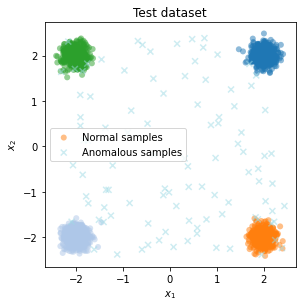

In [19]:
plt.clf()
fig_mx, ax = plt.subplots(nrows=1, ncols=1, figsize=(4.5, 4.5))
ax.scatter(X_np_data_test[idx_inliers, 0], X_np_data_test[idx_inliers, 1], c=cm.tab20(X_targets_test[idx_inliers].astype(float)/15.0),
           edgecolor='none', alpha=0.5, label="Normal samples")

ax.scatter(X_np_data_test[idx_outliers, 0], X_np_data_test[idx_outliers, 1], c=cm.tab20(X_targets_test[idx_outliers].astype(float)/15),
       edgecolor='none', alpha=0.5, label="Anomalous samples", marker='x')

ax.set_xlabel('$x_1$'); ax.set_ylabel('$x_2$')
ax.axis('on')
ax.set_title("Test dataset")
ax.legend()
plt.savefig(save_path_x, transparent=True, bbox_inches='tight')
plt.show()

#### Z Test dataset

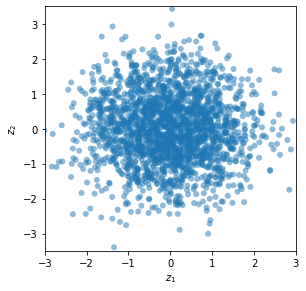

In [20]:
# create Z dataset

datasetZ_test = sample_GMM(X_np_data_test.shape[0], means_z, variances_z, priors_z, sources=('features', ))
save_path = result_dir + 'Z_gmm_data_test.png'
# plot_GMM(dataset, save_path)

Z_np_data_test = datasetZ_test.data['samples']
Z_targets_test = datasetZ_test.data['label']

fig_mx, ax = plt.subplots(nrows=1, ncols=1, figsize=(4.5, 4.5))
ax.scatter(Z_np_data_test[:, 0], Z_np_data_test[:, 1],
           edgecolor='none', alpha=0.5)
ax.set_xlim(-3, 3); ax.set_ylim(-3.5, 3.5)
ax.set_xlabel('$z_1$'); ax.set_ylabel('$z_2$')
ax.axis('on')
plt.savefig(save_path, transparent=True, bbox_inches='tight')
plt.show()

### Testing

In [21]:
feed_dict = {x: X_np_data_test, z:Z_np_data_test}
imz = sess.run(q_z, feed_dict=feed_dict)
rmz = sess.run(rec_z, feed_dict=feed_dict)
imx = sess.run(p_x, feed_dict=feed_dict)
rmx = sess.run(rec_x, feed_dict=feed_dict)
score_dz = sess.run(mahalanobis_dis_z, feed_dict=feed_dict)
score_dxx = sess.run(x_sigmoid_real + x_sigmoid_fake, feed_dict=feed_dict)

score = score_dz #+ score_dxx
score = np.linalg.norm(imz, ord=2, axis=1, keepdims=False)
print(score)
def zmar(imz):
    return np.linalg.norm(imz, ord=2, axis=1, keepdims=False)

[0.87686294 0.9101817  1.2971783  ... 0.36863235 0.14386746 0.29654455]


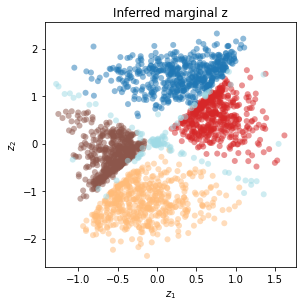

In [22]:
## inferred marginal z
fig_mz, ax = plt.subplots(nrows=1, ncols=1, figsize=(4.5, 4.5))
ll = X_targets_test
ax.scatter(imz[:, 0], imz[:, 1], c=cm.tab20(ll.astype(float)/input_dim/3.0),
        edgecolor='none', alpha=0.5)
#ax.set_xlim(-3, 3); ax.set_ylim(-3.5, 3.5)
ax.set_xlabel('$z_1$'); ax.set_ylabel('$z_2$')
ax.axis('on')
ax.set_title("Inferred marginal z")
plt.savefig(result_dir + 'inferred_{}_mz.png'.format(DATASET), transparent=True, bbox_inches='tight')
plt.show()

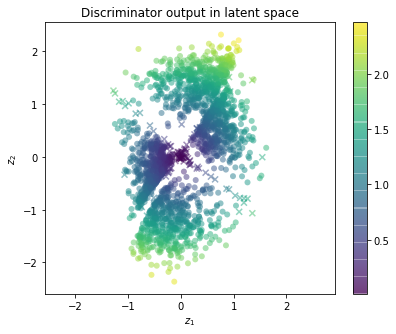

In [23]:
import matplotlib as mpl
## discriminator z choice on latent - v3
fig_mz, ax = plt.subplots(nrows=1, ncols=1, figsize=(6.5, 5))

colors = score#zmar(score)
norm = mpl.colors.Normalize(vmin=min(colors), vmax=max(colors))

im = ax.scatter(imz[idx_inliers, 0], imz[idx_inliers, 1], c=colors[idx_inliers],
        edgecolor='none', alpha=0.5, label="Normal samples", marker='o', norm=norm)

im = ax.scatter(imz[idx_outliers, 0], imz[idx_outliers, 1], c=colors[idx_outliers],
        edgecolor='none', alpha=0.5, label="Anomalous samples", marker='x', norm=norm)
#ax.set_xlim(-3, 3); ax.set_ylim(-3.5, 3.5)
ax.set_xlabel('$z_1$'); ax.set_ylabel('$z_2$')
fig_mz.colorbar(im)
ax.axis('on')
plt.axis('equal')
ax.set_title("Discriminator output in latent space")
plt.savefig(result_dir + 'inferred_{}_mz_disc.png'.format(DATASET), transparent=True, bbox_inches='tight')
plt.show()

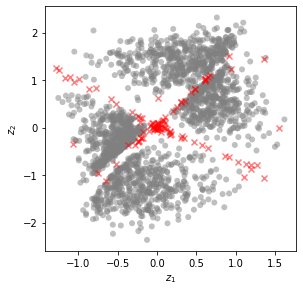

In [24]:
## discriminator z choice on latent - v2
fig_mz, ax = plt.subplots(nrows=1, ncols=1, figsize=(4.5, 4.5))

ax.scatter(imz[idx_inliers][:, 0], imz[idx_inliers][:, 1], c='grey',
        edgecolor='none', alpha=0.5)
ax.scatter(imz[idx_outliers][:, 0], imz[idx_outliers][:, 1], c='r',
        edgecolor='none', alpha=0.5, marker='x')
#ax.set_xlim(-3, 3); ax.set_ylim(-3.5, 3.5)
ax.set_xlabel('$z_1$'); ax.set_ylabel('$z_2$')
ax.axis('on')
plt.savefig(result_dir + 'inferred_{}_mz.png'.format(DATASET), transparent=True, bbox_inches='tight')
plt.show()

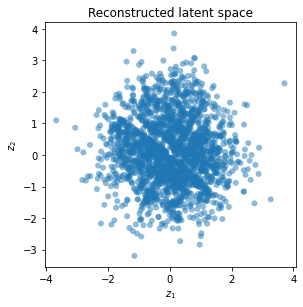

In [25]:
##  reconstructed z
fig_pz, ax = plt.subplots(nrows=1, ncols=1, figsize=(4.5, 4.5))

ax.scatter(rmz[:, 0], rmz[:, 1],
           edgecolor='none', alpha=0.5)
#ax.set_xlim(-3, 3); ax.set_ylim(-3.5, 3.5)
ax.set_xlabel('$z_1$'); ax.set_ylabel('$z_2$')
ax.axis('on')
ax.set_title('Reconstructed latent space')
plt.savefig(result_dir + 'reconstruct_{}_mz.png'.format(DATASET), transparent=True, bbox_inches='tight')
plt.show()

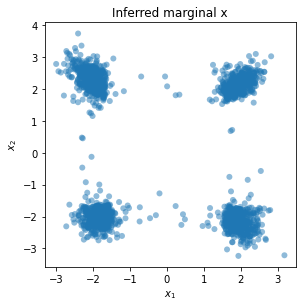

In [26]:
## inferred marginal x
fig_pz, ax = plt.subplots(nrows=1, ncols=1, figsize=(4.5, 4.5))
ax.scatter(imx[:, 0], imx[:, 1],
        edgecolor='none', alpha=0.5)
#ax.set_xlim(-3, 3); ax.set_ylim(-3.5, 3.5)
ax.set_xlabel('$x_1$'); ax.set_ylabel('$x_2$')
ax.axis('on')
ax.set_title("Inferred marginal x")
plt.savefig(result_dir + 'inferred_{}_mx.png'.format(DATASET), transparent=True, bbox_inches='tight')
plt.show()

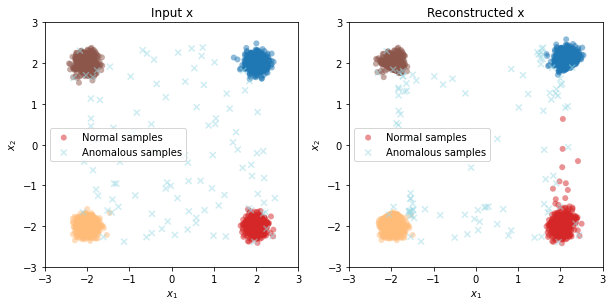

In [27]:
##  reconstructed x
fig_mx, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 4.5))
ax[0].scatter(X_np_data_test[idx_inliers, 0], X_np_data_test[idx_inliers, 1], c=cm.tab20(X_targets_test[idx_inliers].astype(float)/input_dim/3.0),
           edgecolor='none', alpha=0.5, label="Normal samples")
ax[0].scatter(X_np_data_test[idx_outliers, 0], X_np_data_test[idx_outliers, 1], c=cm.tab20(X_targets_test[idx_outliers].astype(float)/input_dim/3.0),
           edgecolor='none', alpha=0.5, label="Anomalous samples", marker='x')
ax[0].set_xlabel('$x_1$'); ax[0].set_ylabel('$x_2$')
ax[0].axis('on')
ax[0].set_xlim(-3, 3); ax[0].set_ylim(-3, 3)
ax[0].legend()
ax[0].set_title("Input x")

ax[1].scatter(rmx[idx_inliers, 0], rmx[idx_inliers, 1], c=cm.tab20(X_targets_test[idx_inliers].astype(float)/input_dim/3.0),
           edgecolor='none', alpha=0.5, label="Normal samples")
ax[1].scatter(rmx[idx_outliers, 0], rmx[idx_outliers, 1], c=cm.tab20(X_targets_test[idx_outliers].astype(float)/input_dim/3.0),
           edgecolor='none', alpha=0.5, label="Anomalous samples", marker='x')
ax[1].set_xlim(-3, 3); ax[1].set_ylim(-3, 3)
ax[1].set_xlabel('$x_1$'); ax[1].set_ylabel('$x_2$')
ax[1].axis('on')
ax[1].legend()
ax[1].set_title("Reconstructed x")
plt.savefig(result_dir + 'reconstruct_{}_mx.png'.format(DATASET), transparent=True, bbox_inches='tight')
plt.show()

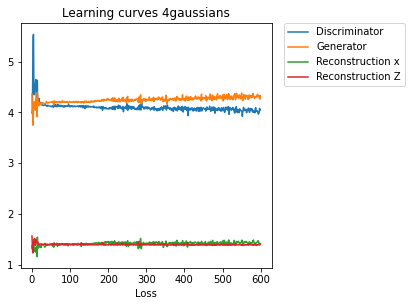

In [28]:
## learning curves
fig_curve, ax = plt.subplots(nrows=1, ncols=1, figsize=(4.5, 4.5))
ax.plot(FD, label="Discriminator")
ax.plot(np.array(FG)[:,0], label="Generator")
ax.plot(np.array(FG)[:,1], label="Reconstruction x")
ax.plot(np.array(FG)[:,2], label="Reconstruction Z")
plt.xlabel('Iteration')
plt.xlabel('Loss')
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
ax.axis('on')
ax.set_title("Learning curves {}".format(DATASET))
plt.savefig(result_dir + 'learning_curves_{}.png'.format(DATASET), bbox_inches='tight')
plt.show()